# Analisis Trip Pengguna Jasa Taksi <a id='intro'></a>

Perusahaan bernama Zuber yang bergerak di bidang `ride-sharing` adalah perusahaan baru yang diluncurkan di Chicago ingin menemukan pola dalam informasi yang tersedia. Perusahaan ini ingin memahami preferensi penumpang dan dampak faktor eksternal pada perjalanan. Kami akan menggunakan `(Structured Query Language) SQL` untuk mengumpulkan data dan melanjutkan ke `Python` untuk di analisis menggunakan `(Exploratory Data Analysis) EDA`. Beberapa analisis berupa tujuan dan hipotesis yang diajukan adalah sebagai berikut:

Dalam SQL:
- Mengumpulkan data perusahaan taksi yang memiliki jumlah trip terbanyak pada tanggal `15-16 November 2017`.
- Berapa banyak perjalanan yang dilakukan perusahaan taksi dengan nama `Kuning` dan `Biru` pada tanggal `1-7 November 2017`?
- Berapa banyak perjalanan yang dilakukan `Flash Cab` dan `Taxi Affiliation Services` pada tanggal `1 - 7 November 2017`?
- Kumpulkan data kondisi cuaca pada hari `Sabtu` berdasarkan perjalanan dari `Loop` ke `O’Hare` pada `November 2017`.

Dengan Python:
- Perusahaan taksi manakah yang memiliki jumlah trip terbanyak pada tanggal `15-16 November 2017`.
- Mengetahui distribusi data jumlah trips dari seluruh perushaan pada tanggal `15-16 November 2017`.
- Mengetahui lokasi favorit (`dropoff_location`) manakah yang sering dikunjungi pengguna selama bulan `November 2017`.
- Mengetahui distribusi data dari rata-rata trip ditiap lokasi `dropoff` selama bulan `November 2017`.
- Menguji hipotesis: Benarkah durasi rata-rata perjalanan dari `Loop` ke `Bandara Internasional O'Hare` berubah pada hari-hari `Sabtu` yang hujan.

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [Tahap 1. Mengumpulkan Data Menggunakan SQL](#cont_1)
     * [1.1 Web Scraping](#cont_2)
     * [1.2 Menghitung dan Mengurutkan Trip Berdasarkan Nama Perusahaan](#cont_3)
     * [1.3 Menghitung Jumlah Trip Berdasarkan Nama Perusahaan yang Menggunakan kata `Yellow` atau `Blue`](#cont_4) 
     * [1.4 Menghitung Jumlah Trip untuk Nama Perusahaan Flash Cab dan Taxi Affiliation Services](#cont_5)
     * [1.5 Mengumpulkan Hasil Akhir Rekaman Cuaca](#cont_6)
* [Tahap 2. Mempersiapkan Datasets](#cont_7)
    * [2.1 Insialisasi Library](#cont_8) 
    * [2.2 Mempersiapkan Dataset `company_name`](#cont_9) 
    * [2.3 Mempersiapkan Dataset `dropoff_location`](#cont_10) 
    * [2.4 Mempersiapkan Dataset `weather`](#cont_11) 
* [Tahap 3. Memperbaiki Datasets](#cont_12)
    * [3.1 Mengecek Duplikat pada Datasets](#cont_13) 
    * [3.2 Mengecek Nilai yang Hilang pada Datasets](#cont_14) 
    * [3.3 Memperbaiki Kualitas Data pada Dataset `company_name`](#cont_15) 
    * [3.4 Memperbaiki Kualitas Data pada Dataset `dropoff_location`](#cont_16) 
    * [3.5 Memperbaiki Kualitas Data pada Dataset `weather`](#cont_17) 
* [Tahap 4. Analisis Data Eksploratif (EDA)](#cont_18)
    * [4.1 Analisis Dataset Perusahaan Taksi](#cont_19) 
    * [4.2 Analisis Dataset Lokasi Dropoff](#cont_20) 
* [Tahap 5. Pengujian Hipotesis](#cont_21)
* [Tahap 6. Kesimpulan Umum](#cont_22)

# Mengumpulkan Data Menggunakan SQL <a id='cont_1'></a>

Pertama, kita perlu menjelajahi semua kumpulan data. Ada beberapa set data yang berkorelasi seperti `neighborhoods`, `cabs`, `trips`, `weather_records`. Ada dataset yang memiliki hubungan di antara mereka, kita akan membuat diagram untuk memvisualisasikan dataset relasional.

Dataset **Neighborhoods** berisi kolom berikut:
- `nama` adalah nama daerah
- `neighborhood_id` adalah kode wilayah

Dataset **Cabs** berisi kolom berikut:
- `cab_id` adalah kode kendaraan
- `vehicle_id` adalah identitas teknis kendaraan
- `company_name` adalah nama perusahaan

Dataset **Trips** berisi kolom berikut:
- `trip_id` adalah identitas trip
- `cab_id` adalah kode kendaraan
- `start_ts` adalah tanggal dan waktu memulai perjalanan (dibulatkan per jam)
- `end_ts` adalah tanggal dan waktu akhir perjalanan (dibulatkan per jam)
- `duration_seconds` adalah durasi perjalanan dalam detik
- `distance_miles` adalah jarak perjalanan dalam mil
- `pickup_location_id` adalah identitas lokasi penjemputan
- `dropoff_location_id`: adalah penurunan identitas lokasi

Dataset **Weather** berisi kolom berikut:
- `record_id` adalah kode perekaman cuaca
- `ts` adalah tanggal dan waktu saat perekaman cuaca dimulai (dibulatkan per jam)
- `suhu` adalah suhu pada `ts`
- `deskripsi` adalah gambaran kondisi cuaca pada suatu waktu, misalnya `hujan ringan` atau `awan tersebar`.

Selanjutnya, kita akan membuat `database relasional` menggunakan semua dataset yang telah dijelaskan sebelumnya:
`PK` adalah `primary key` dan `FK` adalah `foreign key`.

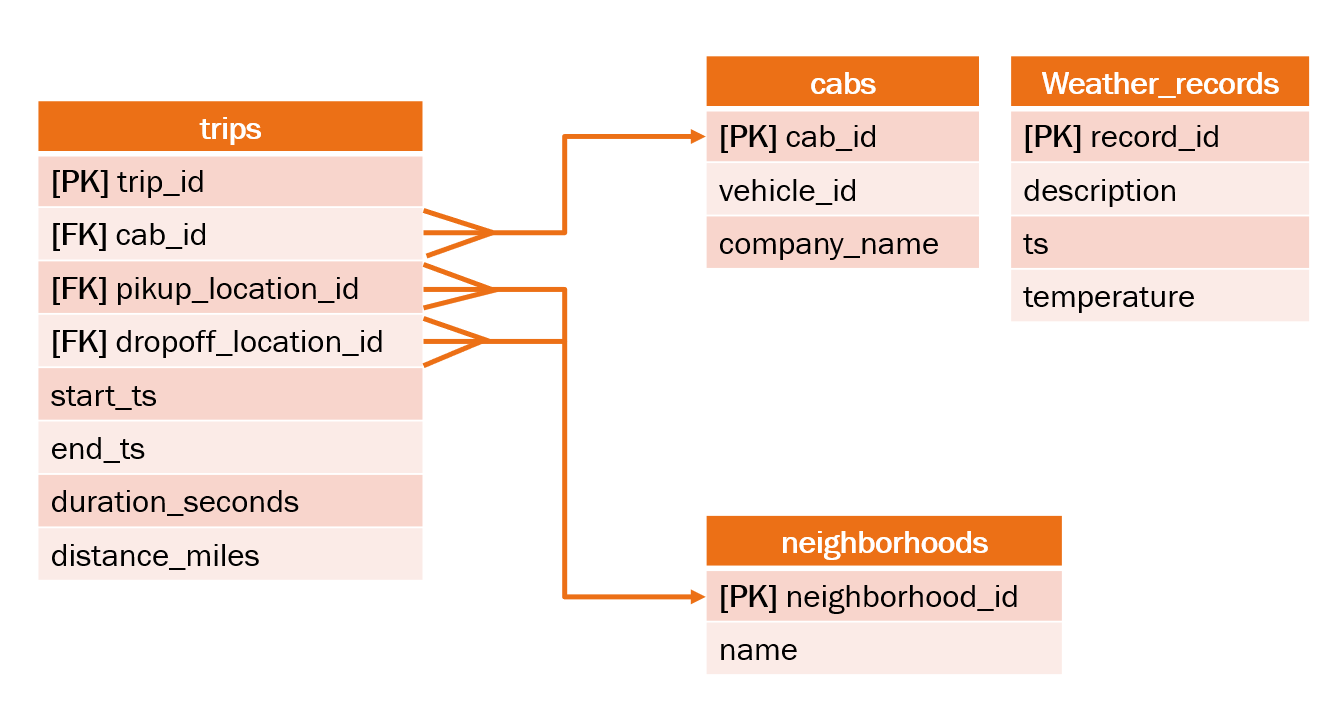

## Web Scraping <a id='cont_2'></a>

Di bagian ini, kami akan melakukan scraping `weather_records` pada server dan mengubahnya menjadi Data Frame. Kita akan menggunakan `TripleTen Server` yang memiliki `weather_records` dengan menggunakan parameter `attrs={"id": "weather_records"}`.

In [24]:
# memuat modul
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [25]:
# URL
URL='https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'

# meminta request ke server
req = requests.get(URL)
soup = BeautifulSoup(req.text)
table = soup.find('table', attrs={"id": "weather_records"})

# mengumpulkan data
heading_table=[]
for row in table.find_all('th'):
    heading_table.append(row.text)   
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

# membuat data frame
weather_records = pd.DataFrame(content, columns = heading_table)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


## Menghitung dan Mengurutkan Trip Berdasarkan Nama Perusahaan <a id='cont_3'></a>

Kita akan menggunakan SQL untuk menghitung dan mengurutkan perjalanan dari kumpulan data `trips` dan `cabs`. Kami mengelompokkannya berdasarkan `company_name` dan mengurutkan hasilnya. Ini kodenya:

```SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
    INNER JOIN 
    trips 
    ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY 
    company_name
ORDER BY 
    trips_amount DESC;
```

==> Hasil:

```python
company_name	trips_amount
Flash Cab	19558
Taxi Affiliation Services	11422
Medallion Leasin	10367
Yellow Cab	9888
.
.
.
2733 - 74600 Benny Jona	7
5874 - 73628 Sergey Cab Corp.	5
2241 - 44667 - Felman Corp, Manuel Alonso	3
3556 - 36214 RC Andrews Cab	2
```

## Menghitung Jumlah Trip Berdasarkan Nama Perusahaan yang Menggunakan kata `Yellow` atau `Blue` <a id='cont_4'></a> 

Kami akan mencari nama perusahaan yang menggunakan kata `Yellow` atau `Blue` untuk DateTime antara `2017-11-01` dan `2017-11-07`. Ini kodenya:

```SQL
SELECT
    cabs.company_name as company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%%Yellow%%'
GROUP BY company_name
UNION ALL
SELECT
    cabs.company_name as company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
    AND cabs.company_name LIKE '%%Blue%%'
GROUP BY company_name;
```

==> Hasil:

```SQL
company_name	trips_amount
Taxi Affiliation Service Yellow	29213
Yellow Cab	33668
Blue Diamond	6764
Blue Ribbon Taxi Association Inc.	17675
```

## Menghitung Jumlah Trip untuk Nama Perusahaan Flash Cab dan Taxi Affiliation Services <a id='cont_5'></a> 

Kita akan mengatur nama perusahaan; jika bukan `Flash Cab` atau `Taxi Affiliation Services` akan menjadi `Other`. Kita akan menghitung DateTime antara `2017-11-01` dan `2017-11-07`. Ini kodenya:

```SQL
SELECT
    CASE 
        WHEN cabs.company_name = 'Flash Cab' THEN 'Flash Cab' 
        WHEN cabs.company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services' 
        ELSE 'Other' 
    END AS company,
    COUNT(trips.trip_id) as trips_amount                
FROM 
    cabs
INNER JOIN 
    trips 
ON 
    trips.cab_id = cabs.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY 
    company
ORDER BY 
    trips_amount DESC;
```

==> Hasil:

```SQL
company	trips_amount
Other	335771
Flash Cab	64084
Taxi Affiliation Services	37583
```

## Mengumpulkan Hasil Akhir Rekaman Cuaca <a id='cont_6'></a> 

Kita akan mengumpulkan data untuk kasus `jika hujan pada hari Sabtu berpengaruh atau tidak` untuk perjalanan dari `Loop (ID=50)` ke `Hare (ID=63)`. Kami akan menganalisisnya nanti menggunakan `Python`. Pertama kita perlu menemukan ID `Hare` dan `Loop` di set data lingkungan. Ini kodenya:

```SQL
SELECT
    neighborhood_id,
    name
FROM
    neighborhoods
WHERE
    name LIKE '%Hare' OR name LIKE 'Loop' 
```

==> Hasil:

```SQL
neighborhood_id	name
50	Loop
63	O'Hare
```

Kedua, Kita akan mengubah deskripsi `weather_contion` menjadi dua kategori: `Bad` dan `Good` untuk penyederhanaan. Ini kodenya:

```SQL
SELECT
    ts,
    CASE
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions
FROM 
    weather_records;
```

==> Hasil:

```SQL
ts	weather_conditions
2017-11-01 00:00:00	Good
2017-11-01 01:00:00	Good
2017-11-01 02:00:00	Good
.
.
.
2017-11-09 05:00:00	Good
2017-11-09 06:00:00	Good
2017-11-09 07:00:00	Good
```

Terakhir, kita akan mengumpulkan data yang kita butuhkan. Ini kodenya:

```SQL
SELECT
    start_ts,
    T.weather_conditions,
    duration_seconds
FROM 
    trips
INNER JOIN (
    SELECT
        ts,
        CASE
            WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
            ELSE 'Good'
        END AS weather_conditions
    FROM 
        weather_records          
) AS T on T.ts = trips.start_ts
WHERE 
    pickup_location_id = 50 AND dropoff_location_id = 63 AND EXTRACT (DOW from trips.start_ts) = 6
ORDER BY trips.trip_id
```

==> Hasil:

```SQL
start_ts	weather_conditions	duration_seconds
2017-11-25 12:00:00	Good	1380
2017-11-25 16:00:00	Good	2410
2017-11-25 14:00:00	Good	1920
.
.
.
2017-11-04 11:00:00	Good	2160
2017-11-11 15:00:00	Good	2400
2017-11-11 20:00:00	Good	1500

Semua data yang terkait dengan pertanyaan akan disimpan di `csv` dan akan dimuat ke `Python` untuk dianalisis.

# Mempersiapkan Datasets <a id='cont_7'></a>

Sebelum melakukan analisis mari kita lakukan beberapa langkah untuk mempersiapkan dataframe mulai dari `memuat library`, `memuat dataframe`, `cleaning dataframe` dan sebagainya.

## Insialisasi Library <a id='cont_8'></a>

Beberapa `library` penunjang untuk mempermudah analisis dengan deskripsi sebagai berikut:
- `Pandas` untuk mengolah dataframe
- `numpy` untuk pengolahan numerik
- `seaborns` dan `matplotlib` untuk visualisasi data
- `scipy` untuk pengujian hipotesis
- `re` untuk membuat regular expression

In [26]:
# mengimpor library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# mendefisikan tema grafik menggunakan seaborns
sns.set_theme(palette='bright')

## Mempersiapkan Dataset `company_name` <a id='cont_9'></a>

Memuat dataframe nama perusahaan `company_name` dari file csv kedalam projek.

In [27]:
# memuat dataset company_name
df_company = pd.read_csv('project_sql_result_01.csv')

Selanjutnya mari kita lihat isi dataframe `company_name`.

In [28]:
# menampilkan sampel dataset company_name
df_company

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3


Terdapat 64 baris dan 2 kolom untuk dataset nama perusahaan.

## Mempersiapkan Dataset `dropoff_location` <a id='cont_10'></a>

Dengan cara yang sama kita akan memuat dataframe untuk `lokasi dropoff` dari file csv ke dalam projek.

In [29]:
# memuat dataset dropoff_location
df_dropoff = pd.read_csv('project_sql_result_04.csv')

Selanjutnya mari kita lihat isi dataframe `dropoff_location`.

In [30]:
# menampilkan sampel dataset dropoff_location
df_dropoff

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


Terdapat 94 baris dan 2 kolom untuk dataset lokasi dropoff.

## Mempersiapkan Dataset `weather` <a id='cont_11'></a>

Dengan cara yang sama kita akan memuat dataframe untuk `weather` dari file csv ke dalam projek.

In [31]:
# memuat dataset weather
df_weather = pd.read_csv('project_sql_result_07.csv')

Selanjutnya mari kita lihat isi dataframe `weather`.

In [32]:
# menampilkan sampel dataset dropoff_location
df_weather

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


Terdapat 1068 baris dan 3 kolom untuk dataset weather.

# Memperbaiki Datasets <a id='cont_12'></a>

Setelah beberapa dataframe dimuat yaitu untuk dataset `df_company`, `df_dropoff` dan `df_weather`, maka selanjutnya kita akan memperbaiki datasets tersebut agar memiliki kualitas yang baik untuk memudahkan analisis. Beberapa langkah untuk memperbaikinya diantaranya sebagai berikut:

## Mengecek Duplikat pada Datasets <a id='cont_13'></a>

Untuk mengecek duplikat pada beberapa datasets beserta jumlahnya bisa menggunakan cara sebagai berikut:

In [33]:
# mengecek duplikat pada dataset company_name
print(f'Jumlah duplikat pada dataset company_name: {df_company.duplicated().sum()}')

# mengecek duplikat pada dataset dropoff_location
print(f'Jumlah duplikat pada dataset dropoff_location: {df_dropoff.duplicated().sum()}')

# mengecek duplikat pada dataset weather
print(f'Jumlah duplikat pada dataset weather: {df_weather.duplicated().sum()}')

Jumlah duplikat pada dataset company_name: 0
Jumlah duplikat pada dataset dropoff_location: 0
Jumlah duplikat pada dataset weather: 197


Terlihat untuk datasets `company_name` dan `dropoff_location` tidak memiliki duplikat, sedangakan untuk dataset `weather` memiliki duplikat sebanyak 197 baris. Mari kita hilangkan duplikat tersebut.

In [34]:
# menhilangkan duplikat pada dataset weather
df_weather.drop_duplicates(inplace=True)

# mengecek kembali duplikat pada dataset weather
print(f'Jumlah duplikat pada dataset weather: {df_weather.duplicated().sum()}')

Jumlah duplikat pada dataset weather: 0


Dataset `weather` sudah tidak memiliki duplikat.

## Mengecek Nilai yang Hilang pada Datasets <a id='cont_14'></a>

Selanjutnya mari kita cek nilai yang hilang pada masing-masing dataset `df_company`, `df_dropoff` dan `df_weather` dengan langkah sebagai berikut:

In [35]:
# mengecek nilai yang hilang pada dataset company_name
print(f'Jumlah nilai yang hilang pada dataset company_name:\n{df_company.isna().sum()}\n')

# mengecek nilai yang hilang pada dataset dropoff_location
print(f'Jumlah nilai yang hilang pada dataset dropoff_location:\n{df_dropoff.isna().sum()}\n')

# mengecek nilai yang hilang pada dataset weather
print(f'Jumlah nilai yang hilang pada dataset weather:\n{df_weather.isna().sum()}\n')

Jumlah nilai yang hilang pada dataset company_name:
company_name    0
trips_amount    0
dtype: int64

Jumlah nilai yang hilang pada dataset dropoff_location:
dropoff_location_name    0
average_trips            0
dtype: int64

Jumlah nilai yang hilang pada dataset weather:
start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64



Terlihat bahwa ketiga datasets tidak memilki nilai yang hilang pada variabel/kolomnya.

## Memperbaiki Kualitas Data pada Dataset `company_name` <a id='cont_15'></a>

Sekarang mari kita perbaiki kualitas dataset dengan memperbaiki tipe data serta nilai yang ada pada dataset yang kita punya. Mari kita telusuri untuk dataset `company_name`.

In [36]:
# menampilkan informasi dataset company_name
print(df_company.info())

# menampilkan sampel dataset company_name
df_company

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3


Pada kolom `company_name` terlihat beberapa value yang berisikan digit nomer yang sedikit mengganggu seperti pada indeks 62 - `2241 - 44667 - Felman Corp`, oleh karena itu kita akan memperbaikinya agar lebih mudah terbaca menggunakan `regular expression`.

In [37]:
# memperbaiki penulisan company name menggunakan regular expression
df_company['company_name'] = df_company['company_name'].apply(lambda x: re.sub(r'[-]+|\d+\s*-\s*\d+|\d+\s*-', '', x))

# menampilkan informasi dataset company_name
print(df_company.info())

# menampilkan sampel data yang baru
df_company

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,Adwar H. Nikola,7
60,Benny Jona,7
61,Sergey Cab Corp.,5
62,"Felman Corp, Manuel Alonso",3


Setelah diperbaiki, value yang ada pada kolom `company_name` sudah sesuai dengan yang diharapkan.

## Memperbaiki Kualitas Data pada Dataset `dropoff_location` <a id='cont_16'></a>

Lakukan dengan cara yang sama untuk mengecek tipe data dan sampel data pada dataset `dropoff_location` sebagai berikut:

In [38]:
# menampilkan informasi dataset dropoff_location
print(df_dropoff.info())

# menampilkan sampel dataset dropoff_location
df_dropoff.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


Terlihat bahwa tipe data pada `average_trips` masih memilki tipe data `float`, oleh karena itu kita akan mengubahnya menjadi tipe data `integer`.

In [39]:
# mengganti tipe data pada kolom average_trips menjadi integer
df_dropoff['average_trips'] = df_dropoff['average_trips'].astype('int')

# menampilkan informasi dataset dropoff_location
print(df_dropoff.info())

# menampilkan sampel dataset dropoff_location
df_dropoff.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     object
 1   average_trips          94 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.2+ KB
None


,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546


Setelah diperbaiki, tipe data pada kolom `average_trips` sudah sesuai.

## Memperbaiki Kualitas Data pada Dataset `weather` <a id='cont_17'></a>

Lakukan dengan cara yang sama untuk mengecek tipe data dan sampel data pada dataset `weather` sebagai berikut:

In [40]:
# menampilkan informasi dataset weather
print(df_weather.info())

# menampilkan sampel dataset weather
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            871 non-null    object 
 1   weather_conditions  871 non-null    object 
 2   duration_seconds    871 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.2+ KB
None


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


Terlihat bahwa tipe data pada `start_ts` dan `duration_seconds` masih memilki tipe data `object` dan `float`, oleh karena itu kita akan mengubahnya menjadi tipe data tertentu. Pada kolom `start_ts` akan diubah menjadi tipe data `datetime` sedangkan `duration_seconds` akan diubah menjadi tipe data `integer`. 

In [41]:
# mengubah tipe data pada kolom start_ts menjadi tipe data tanggal
df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'], format='%Y-%m-%d %H:%M:%S')

# mengganti tipe data pada kolom duration_seconds menjadi integer
df_weather['duration_seconds'] = df_weather['duration_seconds'].astype('int')

# menampilkan informasi dataset weather
print(df_weather.info())

# menampilkan sampel dataset weather
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 23.8+ KB
None


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410
1,2017-11-25 14:00:00,Good,1920
2,2017-11-25 12:00:00,Good,1543
3,2017-11-04 10:00:00,Good,2512
4,2017-11-11 07:00:00,Good,1440


Setelah diperbaiki, tipe data pada kolom yang diperbaiki sudah sesuai dengan yang diharapkan.

# Analisis Data Eksploratif (EDA) <a id='cont_18'></a>

Selanjutnya mari kita eksplorasi dataset tersebut dimulai dari membuat rangkuman sekilas hingga membuat grafik.

## Analisis Dataset Perusahaan Taksi <a id='cont_19'></a>

Mari kita cari tahu rangkuman dari dataset `Perusahaan Taksi` dengan menggunakan `describe` dan `boxplot`. 

       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000


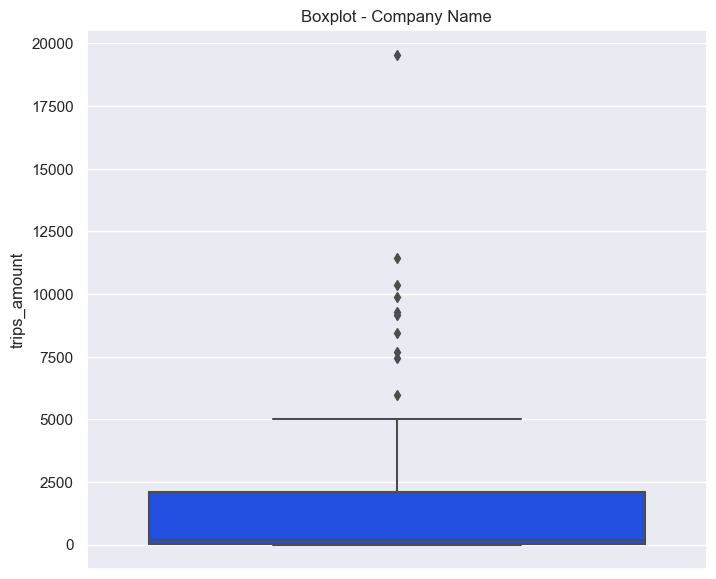

In [42]:
# menampilkan summary dari dataset company_name
print(df_company.describe())

# membuat boxplot
plt.figure(figsize=(8,7))
sns.boxplot(data=df_company, y='trips_amount')
plt.title('Boxplot - Company Name')
plt.show()

Dari informasi diatas terlihat bahwa `rata-rata trip keseluruhan perusahaan taksi` berkisar `2145 trips` untuk tanggal `15-16 November 2017` dengan nilai minimum dan nilai maksimum jumlah trip perusahaan taksi adalah `2 trips dan 19558 trips`. 

Selanjutnya mari kita buat grafik untuk mempermudah dalam membaca informasi.

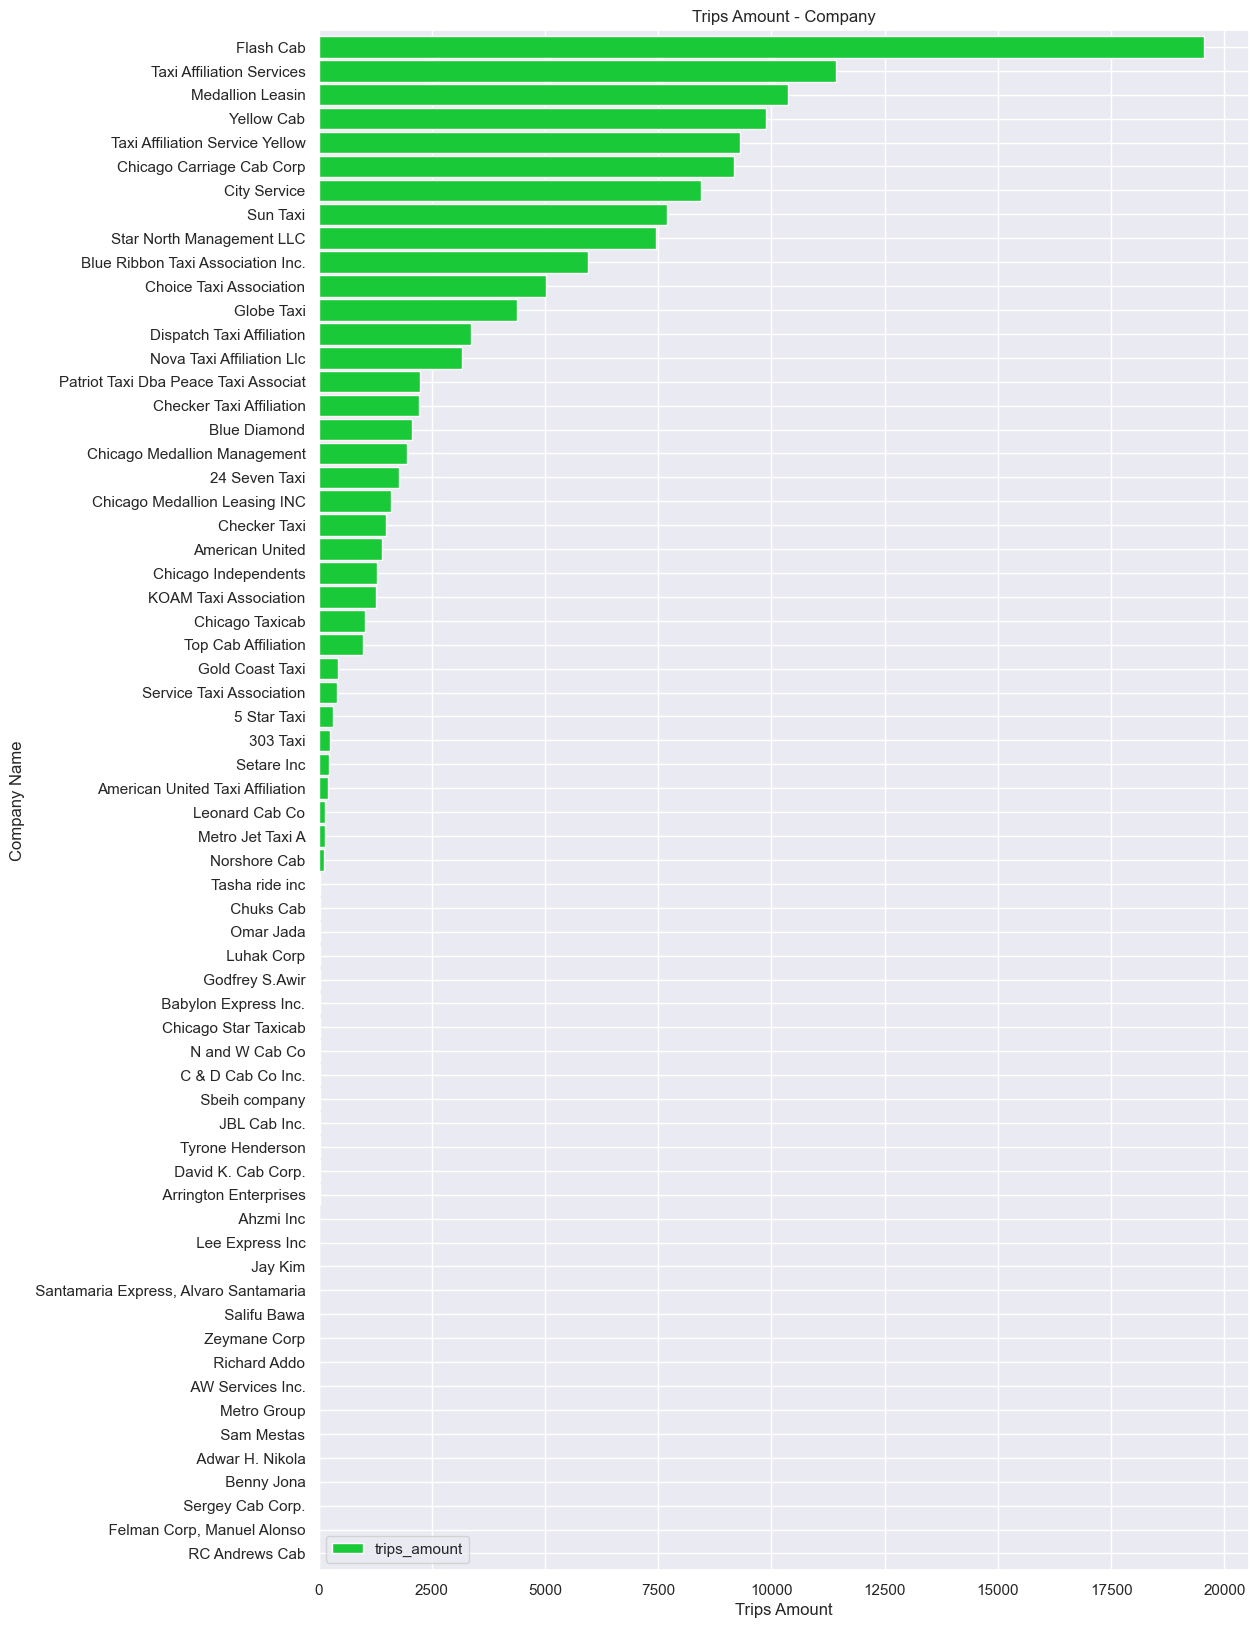

In [43]:
# membuat grafik trip perusahaan taksi 
df_company.sort_values(by='trips_amount',ascending=True).plot(
    kind='barh',
    x='company_name',
    y='trips_amount',
    figsize=(12,20),
    width=0.9,
    color='g'
    )

# membuat judul grafik
plt.title('Trips Amount - Company')

# membuat label grafik
plt.xlabel('Trips Amount')
plt.ylabel('Company Name')

# menampilkan grafik
plt.show()

Dari grafik diatas terlihat bahwa perusahaan dengan jumlah trip terbanyak untuk tanggal `15-16 November 2017` adalah perusahaan `Flash Cab` kemudian `Taxi Affiliation Service` dan seterusnya. Sedangkan perusahaan yang paling rendah dalam jumlah tripnya adalah `RC Andrews Cab` kemudian `Felman Corp. Manuel Alonso` dan seterusnya.

## Analisis Dataset Lokasi Dropoff <a id='cont_20'></a>

Mari kita cari tahu rangkuman dari dataset `Lokasi Dropoff` dengan menggunakan `describe` dan `boxplot`. 

       average_trips
count      94.000000
mean      599.478723
std      1714.555974
min         1.000000
25%        14.000000
50%        51.500000
75%       298.750000
max     10727.000000


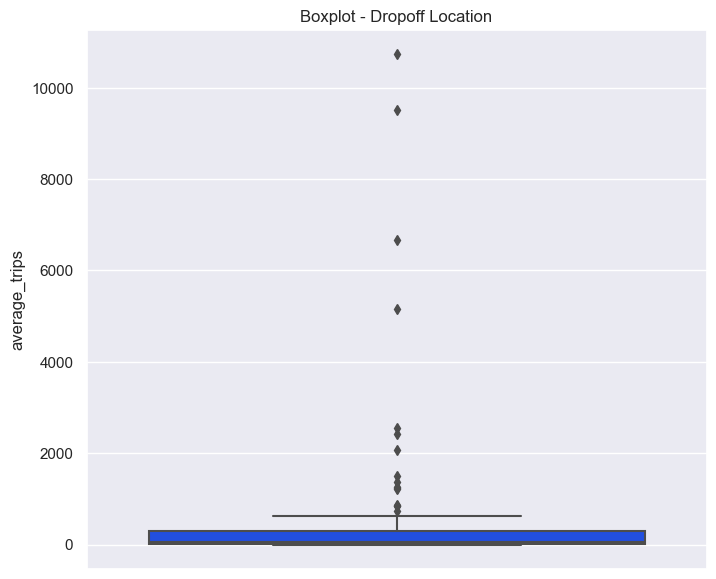

In [44]:
# menampilkan summary dari dataset dropoff_location
print(df_dropoff.describe())

# membuat boxplot
plt.figure(figsize=(8,7))
sns.boxplot(data=df_dropoff, y='average_trips')
plt.title('Boxplot - Dropoff Location')
plt.show()

Dari informasi diatas terlihat bahwa `rata-rata trip dari keseluruhan lokasi dropoff` berkisar `599 trips` untuk bulan `November 2017` dengan nilai minimum dan nilai maksimum rata-rata trip adalah `1 trips dan 10727 trips`. 

Selanjutnya mari kita ambil 10 lokasi dropoff dengan rata-rata trip terbanyak dari dataset yang kita punya.

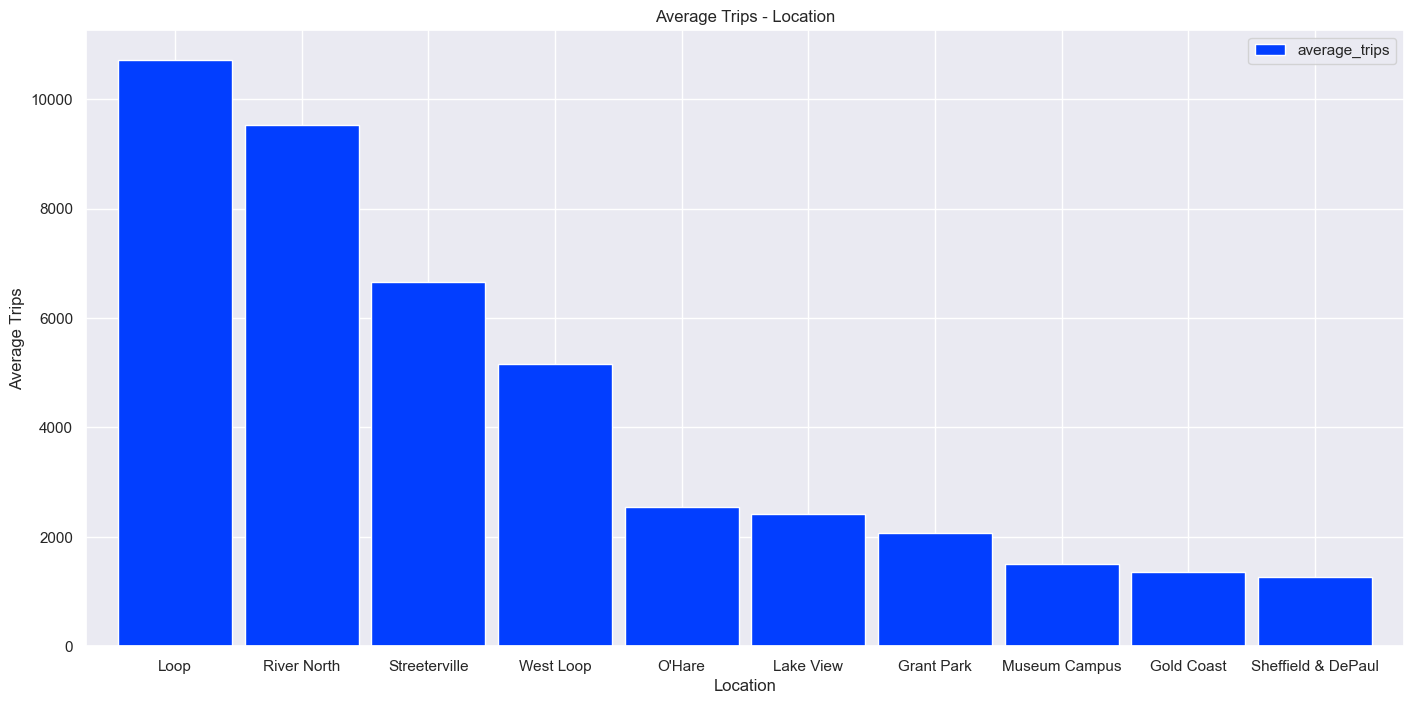

In [45]:
# membuat grafik 10 wilayah yang sering dikunjungi
df_dropoff.iloc[:10].sort_values(by='average_trips',ascending=False).plot(
    kind='bar',
    x='dropoff_location_name',
    y='average_trips',
    figsize=(17,8),
    width=0.9,
    color='b',
    rot=0,
    )

# membuat judul grafik
plt.title('Average Trips - Location')

# membuat label grafik
plt.ylabel('Average Trips')
plt.xlabel('Location')

# menampilkan grafik
plt.show()

Dari grafik diatas terlihat bahwa lokasi dropoff dengan rata-rata jumlah trip terbanyak untuk bulan `November 2017` adalah `Loop` kemudian `River North` dan seterusnya. Sedangkan perusahaan yang paling rendah dalam rata-rata tripnya adalah `Sheffield & DePaul` kemudian `Gold Coast` dan seterusnya.

# Pengujian Hipotesis <a id='cont_21'></a>

Pada langkah ini kita akan menguji suatu hipotesis dimana hipotesisnya adalah "Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan". Mari kita urai menjadi Hipotesis Nol dan Hipotesis Alternatif:
- Hipotesis Nol: Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare `sama` pada hari-hari Sabtu yang hujan
- Hipotesis Alternatif: Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare `berubah` pada hari-hari Sabtu yang hujan

Kita bisa mengujinya hipotesis tersebut dengan menggunakan teknik `ttest_ind` yang ada pada library Scipy. Signifikansi Level yang umum digunakan sebesar 5% (0.05), nilai ini digunakan untuk menguji `Hipotesis Nol`, jika `pvalue` pengujian kurang dari Signifikansi Level, `Hipotesis Nol ditolak`.

In [46]:
# memfilter dataset weather untuk cuaca yang baik dan cuaca yang buruk
good_weather = df_weather.query('weather_conditions == "Good"')
bad_weather = df_weather.query('weather_conditions == "Bad"')

# besarnya signifikan level
alpha = 0.05

# pengujian hipotesis
result = st.ttest_ind(good_weather['duration_seconds'],bad_weather['duration_seconds'])
pvalue = result.pvalue
print(f'Nilai p-value: {pvalue}')

if result.pvalue < alpha:
    print('Hipotesis Nol Ditolak')
else:
    print('Tidak Bisa Menolak Hiptesis Nol')

Nilai p-value: 7.397770692813658e-08
Hipotesis Nol Ditolak


Hipotesis Nol Ditolak, sehingga Hipotesis Alternatif yang diterima bahwa `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan`.

# Kesimpulan Umum <a id='cont_22'></a>

Dari uraian analisis diatas kita sudah melakukan pembuatan dataframe dimana data berasal dari website yang diubah menjadi dataframe. Perbaikan kualitas data dilakukan dimulai dengan mencari duplikat, nilai yang hilang, mengubah tipe data dan mengubah nilai data menggunakan regular expression. Kita menggunakan `SQL` untuk mengumpulkan beberapa data spesifik dari kumpulan data dan terus menggunakan `Python` untuk `Exploratory Data Analysis (EDA)`. Beberapa rangkuman yang bisa dijabarkan sebagai berikut:

- Terdapat dua nama perusahaan yang menggunakan `Yellow` sebagai nama seperti `Taxi Affiliation Service Yellow` dan `Yellow Cab` dengan trip mereka dari `1 – 7 November 2017` masing-masing `29213` dan `33668 trip`. Di sisi lain untuk nama `Blue` seperti `Blue Diamond` dan `Blue Ribbon Taxi Association Inc.` masing-masing `6764` dan `17675` trip.
- `Flash Cab` memiliki jumlah perjalanan terbanyak pada periode `1 - 7 November 2017` sebanyak `64084 trip` dan `Taxi Affiliation Services` hanya memiliki `37583 trip`.
- `Rata-rata trip keseluruhan perusahaan taksi` berkisar `2145 trips` untuk tanggal `15-16 November 2017` dengan nilai minimum dan nilai maksimum jumlah trip perusahaan taksi adalah `2 trips dan 19558 trips`. 
- Jumlah trip terbanyak untuk tanggal `15-16 November 2017` adalah perusahaan `Flash Cab`. Sedangkan perusahaan yang paling rendah dalam jumlah tripnya adalah `RC Andrews Cab`.
- `Rata-rata trip dari keseluruhan lokasi dropoff` berkisar `599 trips` untuk bulan `November 2017` dengan nilai minimum dan nilai maksimum rata-rata trip adalah `1 trips dan 10727 trips`. 
- Lokasi dropoff dengan rata-rata jumlah trip terbanyak untuk bulan `November 2017` adalah `Loop`. Sedangkan perusahaan yang paling rendah dalam rata-rata tripnya adalah `Sheffield & DePaul`.
- Pengujian Hipotesis: `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan` menghasilkan penolakan terhadap Hipotesis Nol, sehingga Hipotesis Alternatif yang diterima bahwa `Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah pada hari-hari Sabtu yang hujan`.
